# Сборный проект

Рассматриваются данные из интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение предоставленных данных

### Подключим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  
plt.rcParams.update({'figure.max_open_warning': 0}) #По убедительной просьбе питона добавить эту строчку (в предупреждении)
from scipy import stats as st


### Посмотрим на данные целиком

In [2]:
data =pd.read_csv('/datasets/games.csv')
data

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Нужно поменять тип данных в year_of_release на Int - так как, как следует из названия столбца, нам интересен только год; и в user_score - на float, так как оценки пользователей ставились в численном формате от 0 до 10

### Проверим число пропусков

In [4]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Значимое количество пропусков наблюдается в столбцах critic_score, user_score и rating. Вероятно, это связано с тем, что не всем играм пользователи ставят оценки: это может касаться как новейших игр, так и достаточно старых, появившихся ещё до возникновения  специальных платформ.Предполагаю, что сделать с ними ничего нельзя. Также есть пропуски в year_of_release и, совсем незначительное, в Name и Genre. Вероятно, это техническая ошибка.

### Проверим дубликаты

In [5]:
data.duplicated().sum()
#Полных дубликатов нет

0

In [6]:
data['Name'].duplicated().sum()

5155

In [7]:
duplicated=data[data['Name'].duplicated()]
duplicated
#Как видно из 23 и 42 строки, "дубликатами" стали игры, оцененные на нескольких платформах.  
#Значит, ошибки нет, и удалять их не нужно.

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
35,Call of Duty: Black Ops II,X360,2012.0,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M
37,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
...,...,...,...,...,...,...,...,...,...,...,...
16706,Men in Black II: Alien Escape,GC,2003.0,Shooter,0.01,0.00,0.00,0.00,NaN,tbd,T
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


 ### На всякий случай проверим адекватность значений

In [8]:
data['Year_of_Release'].describe()
#Значения в year_of_release адекватные: минимальный год выпуска - 1980, максимальный - 2016.

count    16446.000000
mean      2006.484616
std          5.877050
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: Year_of_Release, dtype: float64

In [9]:
data['Critic_Score'].describe()
#Оценки критиков тоже адекватны: от 13 до 98 баллов (из документации максимальное число баллов - 100)

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

In [10]:
data['User_Score'].describe()
#А вот и tbd. Тогда посмотрим на максимальное и минимальное значение после обработки этого столбца

count     10014
unique       96
top         tbd
freq       2424
Name: User_Score, dtype: object

In [11]:
data.sort_values(by='User_Score').head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
2835,My Little Pony: Pinkie Pie's Party,DS,2008.0,Adventure,0.66,0.00,0.0,0.06,NaN,0,E
13682,Myth Makers: Trixie in Toyland,Wii,2008.0,Platform,0.04,0.00,0.0,0.00,NaN,0.2,E
9970,Madden NFL 17,PS3,2016.0,Sports,0.07,0.02,0.0,0.02,NaN,0.2,E
5764,Happy Feet,DS,2006.0,Action,0.27,0.01,0.0,0.02,NaN,0.3,E
13380,Billy the Wizard: Rocket Broomstick Racing,Wii,2007.0,Racing,0.04,0.00,0.0,0.00,NaN,0.3,E


## Обработка данных

### Изменение регистра

In [12]:
#Приведем названия столбцов к "классическому" написанию - в нижнем регистре. 
data.columns=data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Изменение типов данных; изучение Tbd

In [13]:
data['year_of_release']= data['year_of_release'].astype('Int64')
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [14]:
data_tbd=data[data['user_score']=='tbd']
data_tbd

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Из таблицы неочевидно, что связывает строки с tbd. Гугл в помощь:
TBD - to be determined  - означает, что оценка ещё не определена. Собственно, это альтернатива NaN, но с обещанием скоро выяснить. Но нас интересует происходящее сейчас, поэтому заменим все tbd на NaN.

In [15]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
# Теперь ничего не мешает поменять тип данных на float
data['user_score']=data['user_score'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


In [16]:
#Вернёмся к проверке адекватности данных
data['user_score'].describe()
#Итак, и в этом столбце данные адекватные: от 0 до 9.7 (по документации максимум 10)

count    7590.000000
mean        7.125046
std         1.500006
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

### Столбец с суммарными продажами

In [17]:
#Создадим столбец с суммарными продажами
data['all_sales']=data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


### Заполнение пропусков в столбцах  year_of_release, name и genre

Попробуем заменить часть пропусков в year_of_release. Это получится сделать, если игру выпускали больше чем на одной платформе, и год указан на второй.

In [18]:
# В этом столбце 269 пропусков из 16715 значений. Это 1.6 % - можем удалить
data.dropna(subset=['year_of_release'], inplace=True)

In [19]:
#Строки с пропусками в этих колонках составляют около 0,01% (2 из 16000). Можно смело удалять.
data.dropna(subset=['name'], inplace=True)
data.dropna(subset=['genre'], inplace=True)
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
all_sales             0
dtype: int64

### Итоги предобработки
Итак, в результате предобработки данных мы убедились, что предоставленные данные адекватны: нет невозможных значений оценок критиков или пользователей, а также годов выпуска; нет дубликатов. Есть пропуски в столбцах year_of_release, user_score и critic_score: в первом случае часть пропусков заполнили с помощью информации с других платформ, в последних двух оставили, как есть, т.к вероятнее всего это не ошибка, и этих оценок действительно нет. Обозначения "tbd" - to be determined - также означающие, что оценок ещё нет, были приведены к общему виду NaN. Также были удалены строки с пропусками в графе "жанр" и "имя", т.к их количество было пренебрежимо мало по сравнению с общим количеством строк Названия колонок были приведены к классическому виду "snake_case". Также был создан столбец с суммарными продажами игры в мире.

## Исследовательский анализ

### Количество игр в зависимости от года выпуска

In [20]:
games_by_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_by_year

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Text(0, 0.5, 'Количество выпущенных игр')

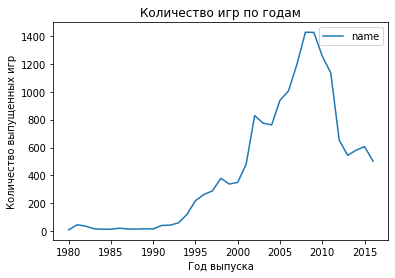

In [21]:
#Для наглядности построим график
games_by_year.plot()
plt.title("Количество игр по годам")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")

Можно видеть, что начиная примерно с 1995 года количество выпускаемых игр в год стало резко возрастать. Вероятно, это связано с развитием технологий и возрастанием доступности ПК для обычных пользователей. Пик приходится приблизительно на 2008-2009 год, после чего начинается спад. Это можно объяснить развитием мобильных телефонов: часть аудитории, а следовательно, и часть разработчиков, перешла от консольных игр к мобильным приложениям. Кроме того, из-за растущей конкуренции (а ведь старые игры всё ещё доступны по большей части) разработчикам приходится вкладывать больше усилий и времени в игру, чтобы та стала популярной и покрыло затраты.

К 2016 году количество выпускаемых консольных игр за год находится приблизительно на уровне 2002-2003 года. 

### Количество игр в зависимости от платформы

In [22]:
games_on_platform = data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values(
    by='all_sales', ascending=False)
games_on_platform

,all_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Можно видеть, что самыми крупными платформами являются PS2, X360, PS3, Wii, DS и PS. Следующая за ними по порядку GBA уже значительно меньше. Будем рассматривать их.

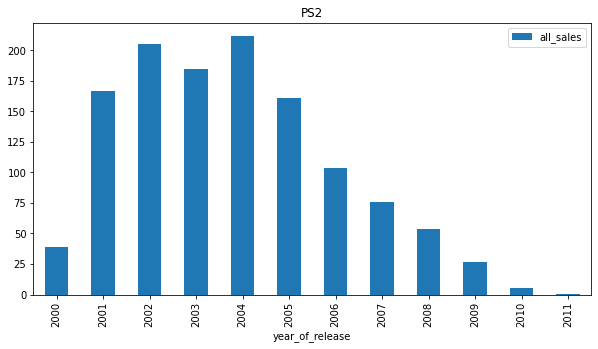

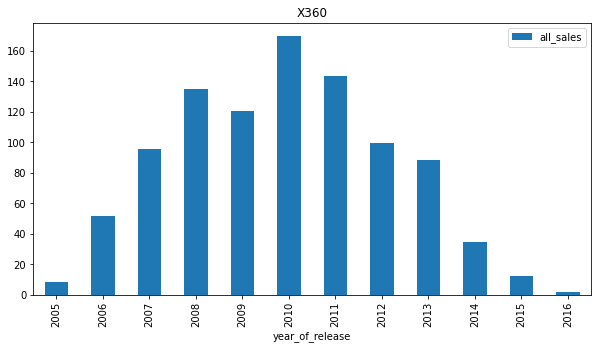

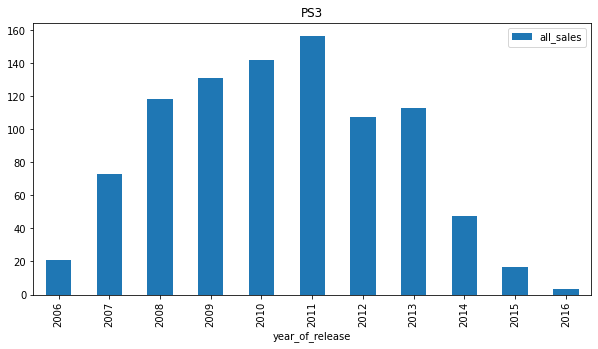

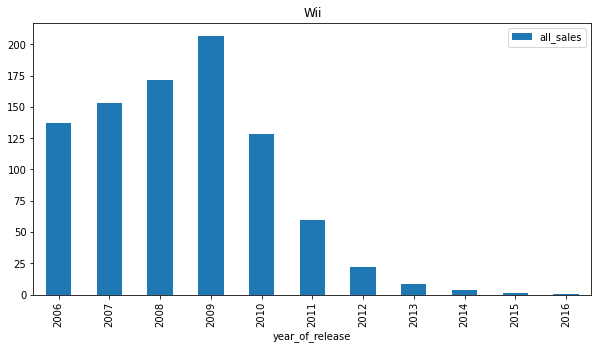

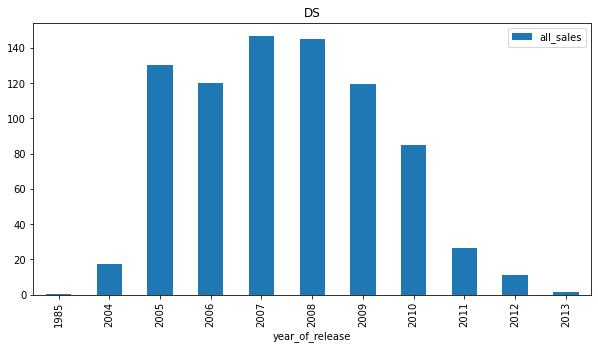

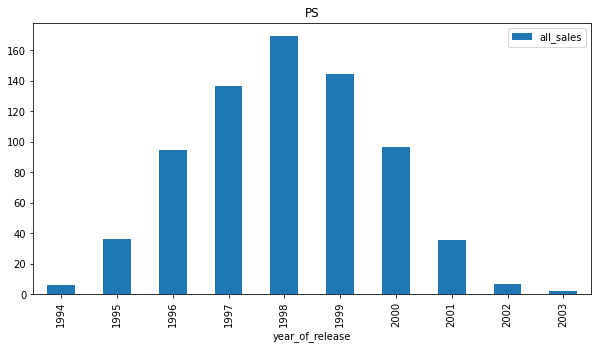

In [23]:
top_platform=['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
for i in top_platform:
    data[data['platform'] == i].pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').plot(kind='bar', figsize=(10,5))
    plt.title(i)

Из интереса посмотрим на данные по остальным платформам.

In [24]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

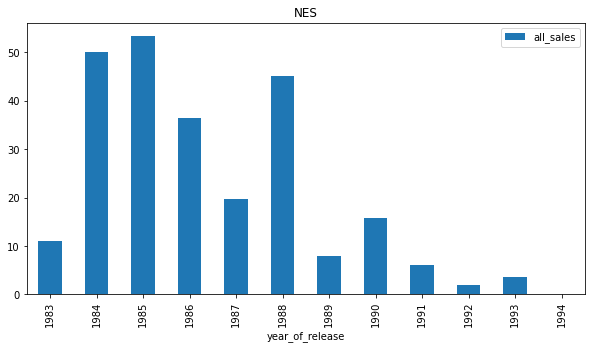

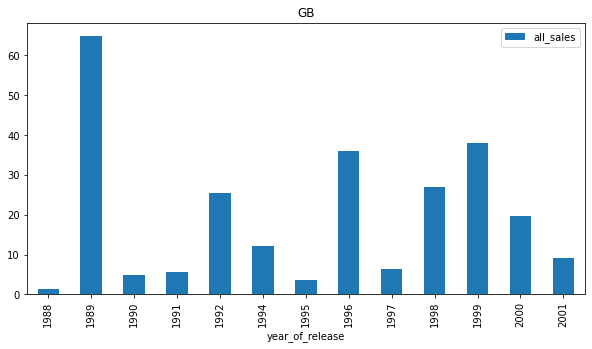

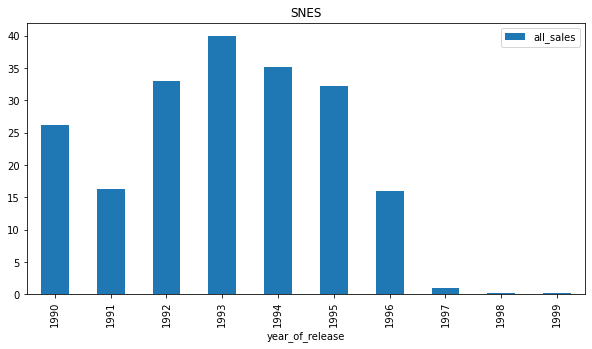

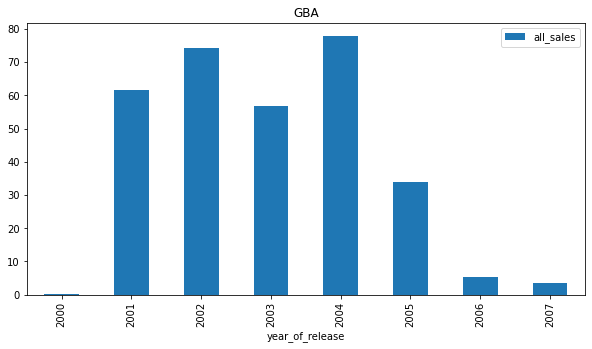

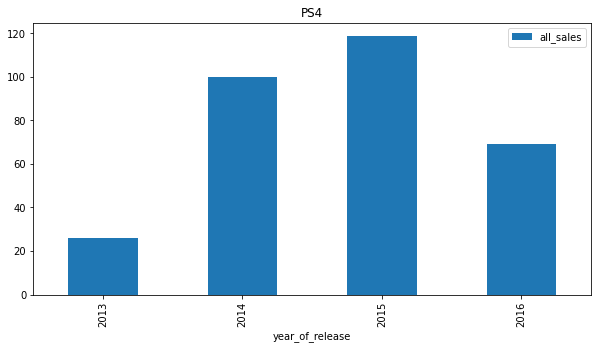

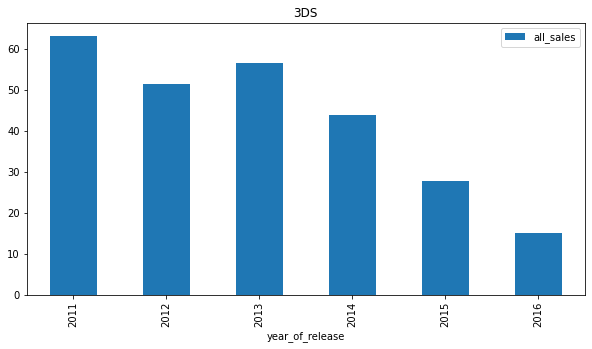

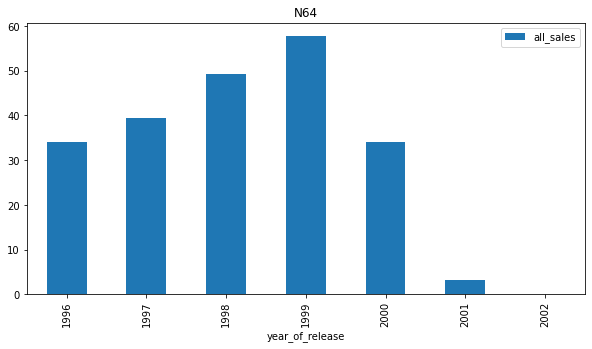

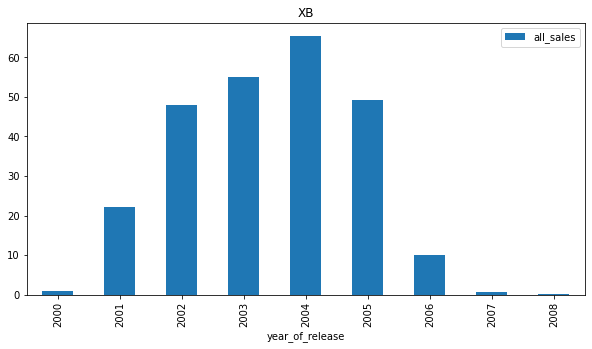

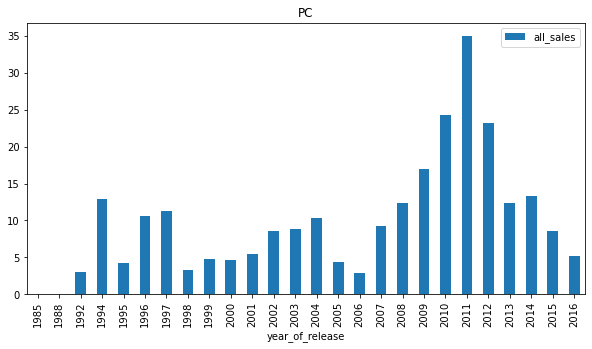

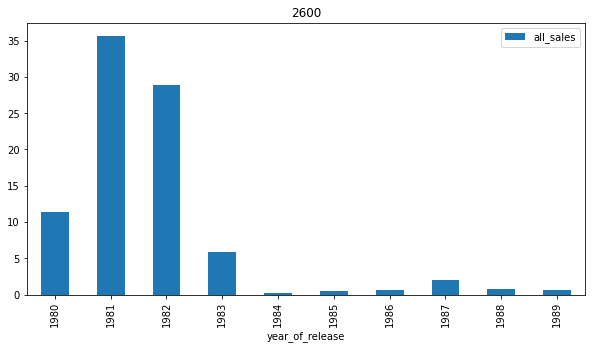

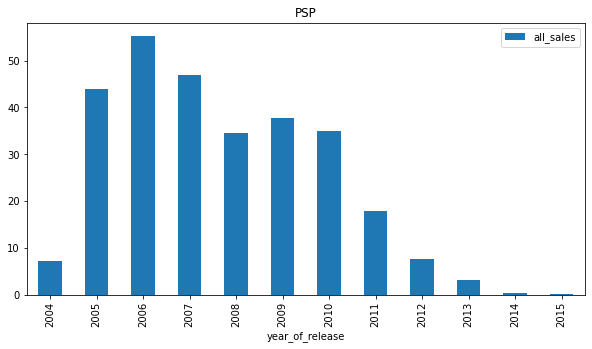

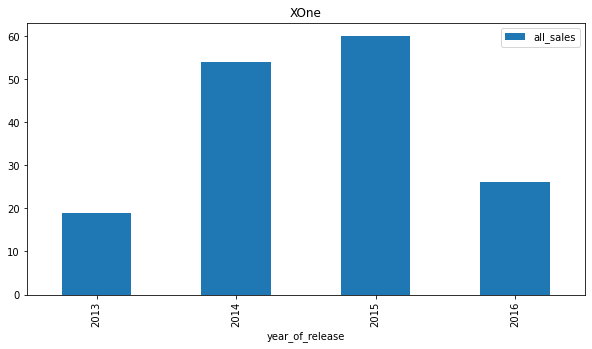

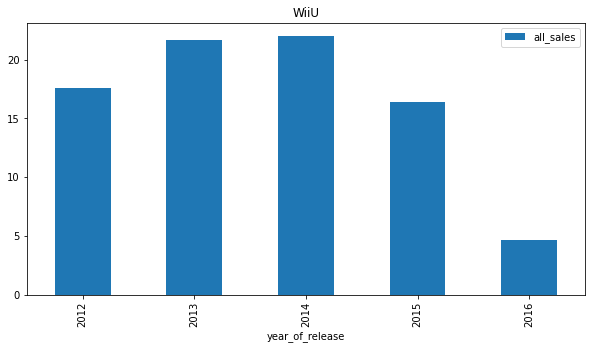

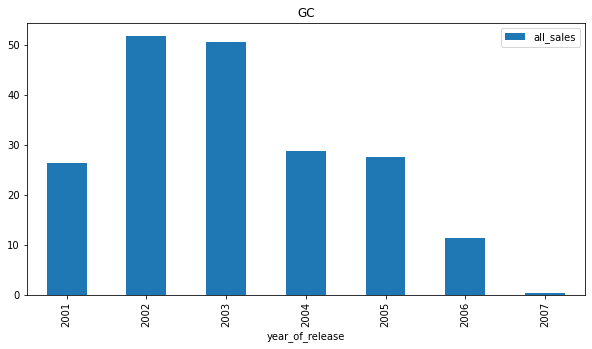

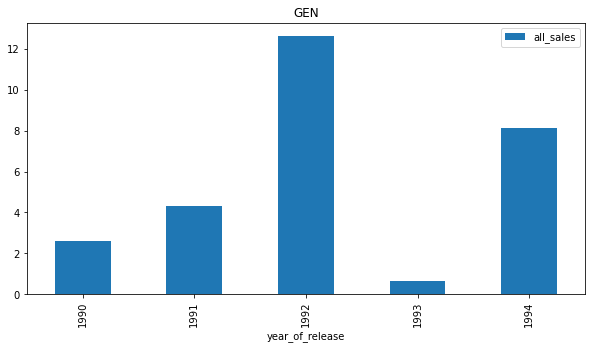

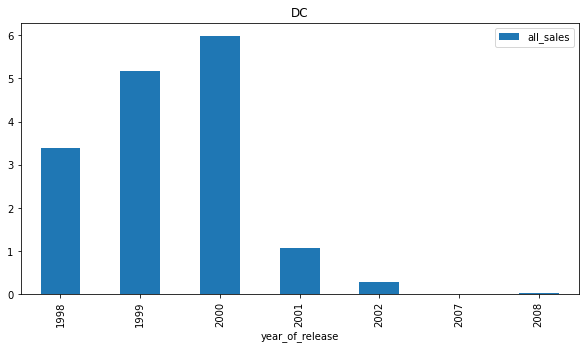

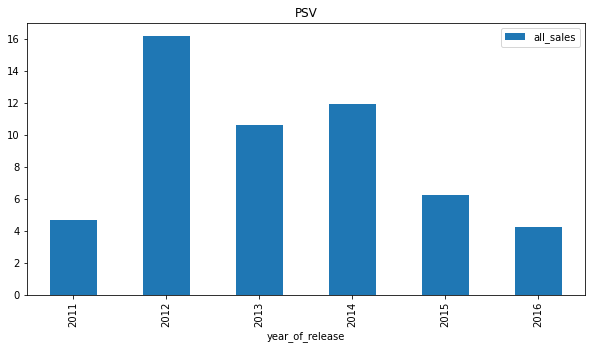

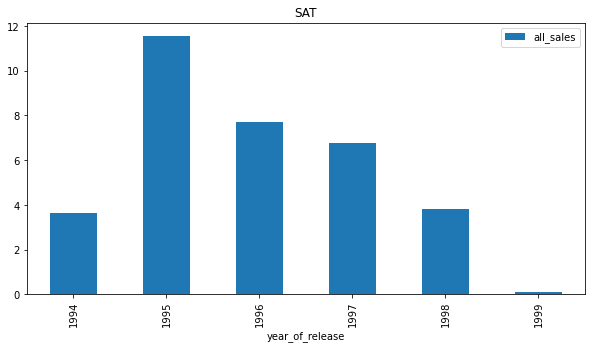

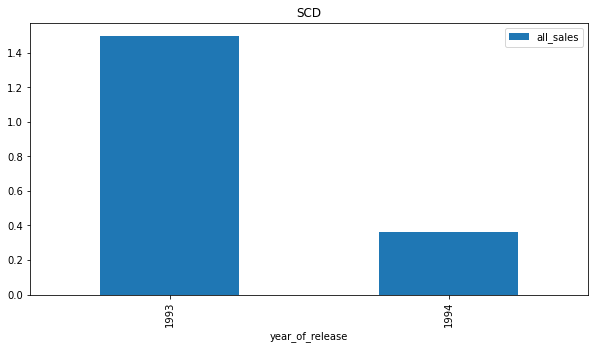

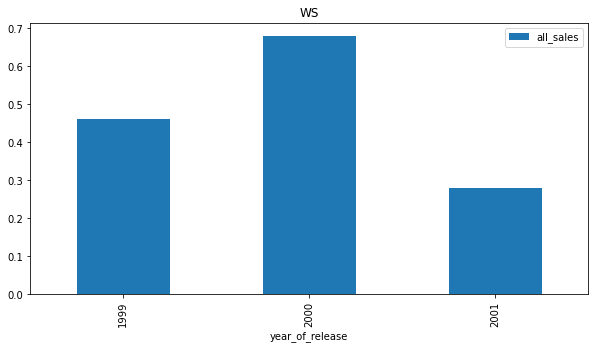

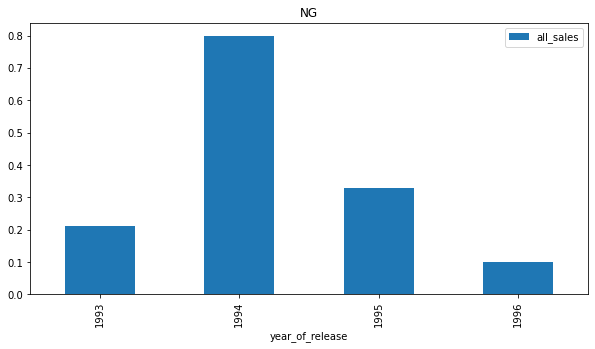

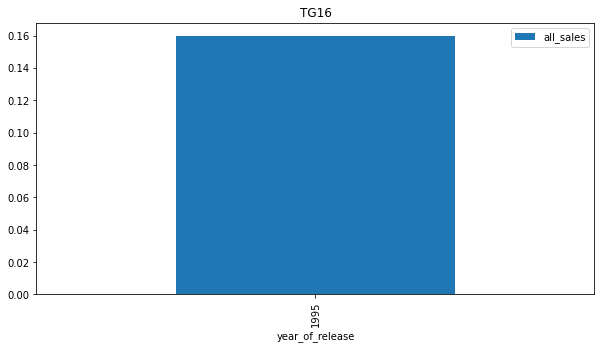

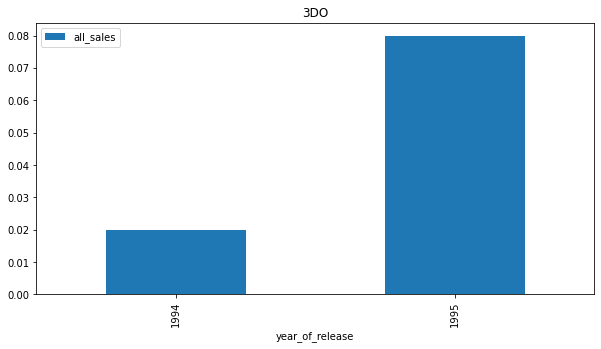

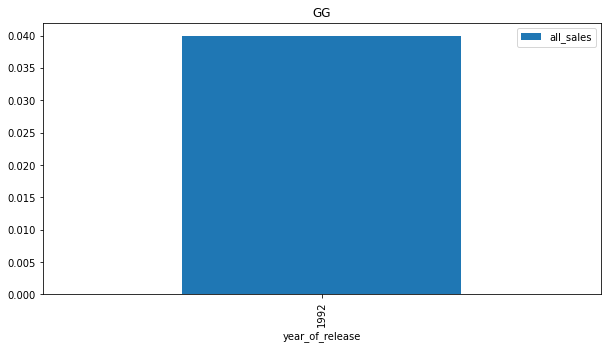

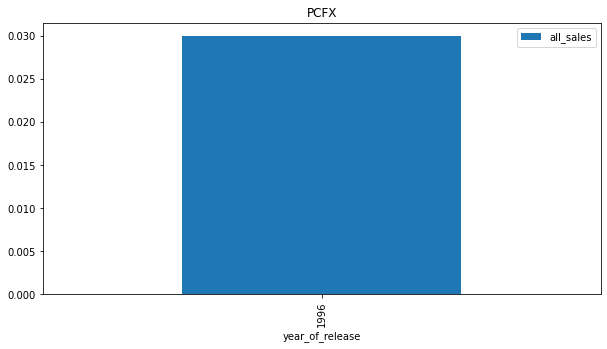

In [25]:
not_top=[ 'NES', 'GB', 'SNES', 'GBA','PS4', '3DS', 'N64', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX']
for i in not_top:
    data[data['platform'] == i].pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').plot(kind='bar', figsize=(10,5))
    plt.title(i)

Итак, можно сделать вывод, что среднее время жизни платформ - примерно 8-10 лет. Причём к 2016 году большая часть из рассматриваемых платформ уже прекратило своё существование.  И, как уже было отмечено ранее, количество выпускаемых игр к 2016 году снизилось.

### Определение актуального периода
Будем рассматривать период в 3 года, чтобы исключить "отжившие" платформы и тренды

In [26]:
actual=data[data['year_of_release']>=2013]
actual

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [27]:
actual['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

В список попали также платформы, не существующие к 2016 году (PSP, PS2, DS ). Учитывая, что цель анализа - выявить потенциально популярные платформы, их нужно выкинуть.

Актуальные платформы: Wii, X360, PS3, PSV, PS4, WiiU, XOne, PC, 3DS

In [28]:
alive_platforms = ['Wii', 'X360', 'PS3', 'PSV', 'PS4', 'WiiU', 'XOne', 'PC', '3DS']
actual=actual[actual['platform'].isin(alive_platforms)]
actual.groupby('platform')['all_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.040,0.090,0.280,14.60
PC,189.0,0.208624,0.352304,0.01,0.030,0.080,0.230,3.05
PS3,345.0,0.525884,1.451939,0.01,0.040,0.150,0.510,21.05
PS4,392.0,0.801378,1.609456,0.01,0.060,0.200,0.730,14.63
PSV,358.0,0.092151,0.153816,0.01,0.020,0.040,0.110,1.96
Wii,23.0,0.593913,0.915432,0.01,0.045,0.180,0.755,3.58
WiiU,115.0,0.562000,1.038778,0.01,0.060,0.200,0.595,7.09
X360,186.0,0.735484,1.663275,0.01,0.080,0.265,0.795,16.27
XOne,247.0,0.645020,1.036139,0.01,0.060,0.220,0.685,7.39


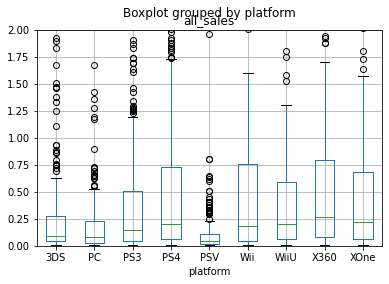

<Figure size 2880x2160 with 0 Axes>

In [29]:
actual.boxplot(column='all_sales', by='platform');
plt.ylim(0,2)
plt.figure(figsize=(40,30))
plt.show()

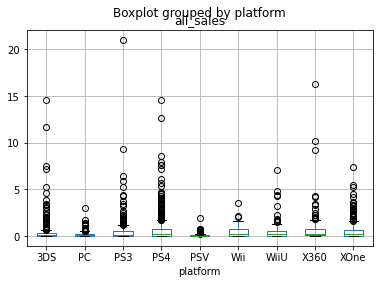

<Figure size 2880x2160 with 0 Axes>

In [30]:
#График без обрезки
actual.boxplot(column='all_sales', by='platform');
plt.figure(figsize=(40,30))
plt.show()

Итак, успешнее всего продажи у X360, PS3, XOne и WiiU. У PS4 и Wii - меньше, и совсем немного у 3DS, PC и PSV. Потенциально прибыльными, вероятно, можно считать первые 4.

### Как влияют на продажи отзывы пользователей и критиков

Рассмотрим продажи внутри одной популярной платформы: X360

#### X360

In [31]:
#Корреляция между оценками пользователей и продажами 
xbox_360 =data[data['platform']=='X360']
xbox_360['user_score'].corr(xbox_360['all_sales'])

0.11418661214018049

<AxesSubplot:xlabel='user_score'>

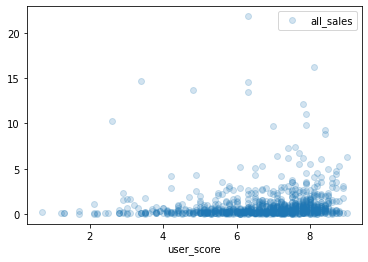

In [32]:
xbox_360.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)

In [33]:
#Корреляция между оценками критиков и продажами 
xbox_360['critic_score'].corr(xbox_360['all_sales'])

0.39286589254006954

<AxesSubplot:xlabel='critic_score'>

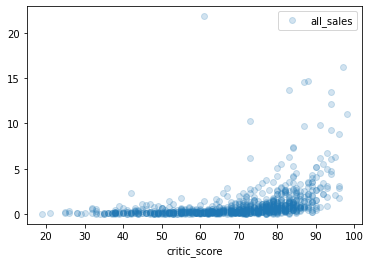

In [34]:
xbox_360.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)

Итак, корреляция между продажами игры на платформе Xbox_360  и отзывами пользователей очень слабая - 0.11; между продажами игры и отзывами критиков - слабая - 0.39.  Посмотрим, что происходит на других платформах:

#### Wii

0.11283121360773772

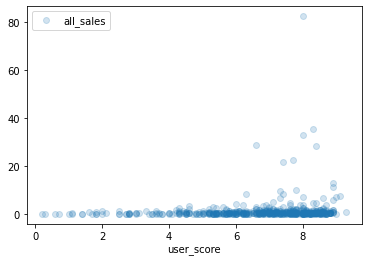

In [35]:
#Корреляция между оценками пользователей и продажами 
wii =data[data['platform']=='Wii']
wii.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
wii['user_score'].corr(wii['all_sales'])
#Корреляция очень слабая

0.17790728577594908

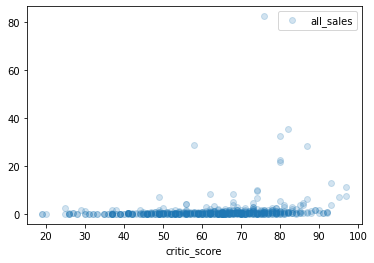

In [36]:
#Корреляция между оценками критиков и продажами 
wii.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
wii['critic_score'].corr(wii['all_sales'])
#Корреляция очень слабая

#### PS3

0.12841562938563006

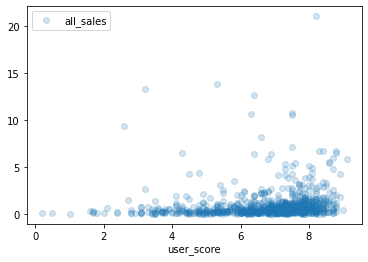

In [37]:
#Корреляция между оценками пользователей и продажами 
ps3 =data[data['platform']=='PS3']
ps3.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
ps3['user_score'].corr(ps3['all_sales'])
#Корреляция очень слабая

0.4327589578997135

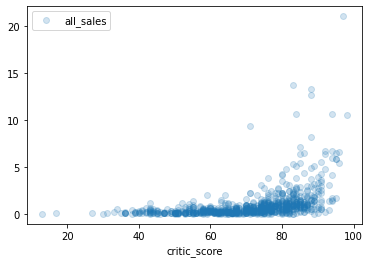

In [38]:
#Корреляция между оценками критиков и продажами 
ps3.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
ps3['critic_score'].corr(ps3['all_sales'])
#Корреляция слабая

#### PSV

0.0134887568358865

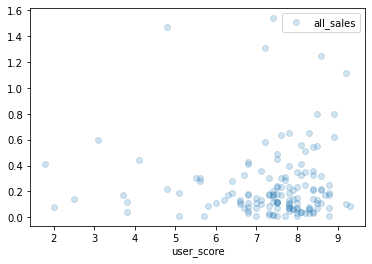

In [39]:
#Корреляция между оценками пользователей и продажами 
psv =data[data['platform']=='PSV']
psv.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
psv['user_score'].corr(psv['all_sales'])
#Корреляция не наблюдается

0.13176292727608935

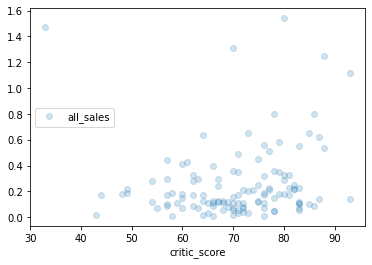

In [40]:
#Корреляция между оценками критиков и продажами 
psv.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
psv['critic_score'].corr(psv['all_sales'])
#Корреляция очень слабая

#### PS4

-0.031957110204556376

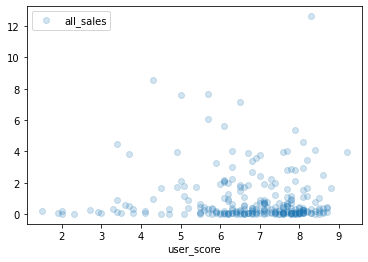

In [41]:
#Корреляция между оценками пользователей и продажами 
ps4 =data[data['platform']=='PS4']
ps4.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
ps4['user_score'].corr(ps4['all_sales'])
#Корреляция не наблюдается

0.40656790206178095

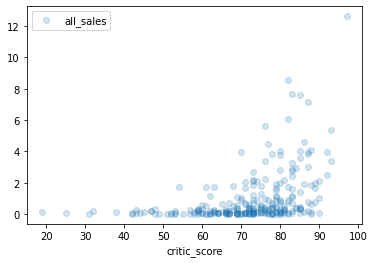

In [42]:
#Корреляция между оценками критиков и продажами 
ps4.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
ps4['critic_score'].corr(ps4['all_sales'])
#Корреляция слабая

#### WiiU

0.4002190202148617

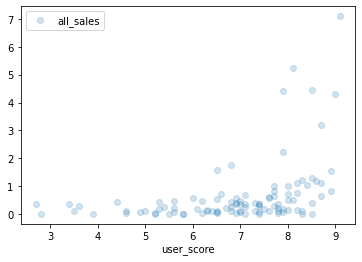

In [43]:
#Корреляция между оценками пользователей и продажами 
wiiu =data[data['platform']=='WiiU']
wiiu.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
wiiu['user_score'].corr(wiiu['all_sales'])
#Корреляция слабая

0.34837976012017485

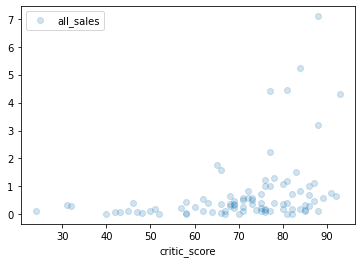

In [44]:
#Корреляция между оценками критиков и продажами 
wiiu.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
wiiu['critic_score'].corr(wiiu['all_sales'])
#Корреляция слабая

#### XOne

-0.06892505328279414

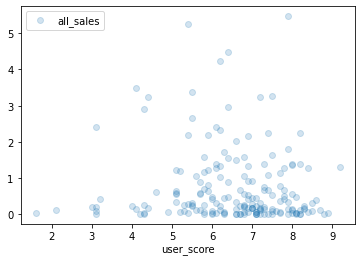

In [45]:
#Корреляция между оценками пользователей и продажами 
xone =data[data['platform']=='XOne']
xone.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
xone['user_score'].corr(xone['all_sales'])
#Корреляция не наблюдается

0.4169983280084017

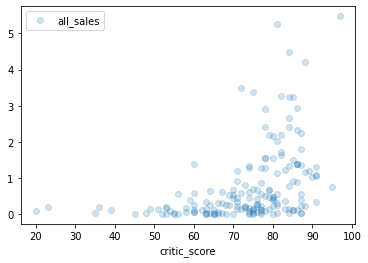

In [46]:
#Корреляция между оценками критиков и продажами 
xone.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
xone['critic_score'].corr(xone['all_sales'])
#Корреляция средняя

#### PC

0.012904741611451175

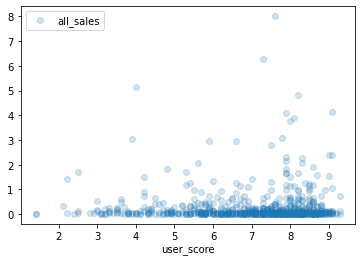

In [47]:
#Корреляция между оценками пользователей и продажами 
pc =data[data['platform']=='PC']
pc.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
pc['user_score'].corr(pc['all_sales'])
#Корелляция не наблюдается

0.257394718400985

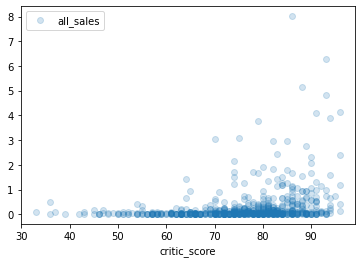

In [48]:
#Корреляция между оценками критиков и продажами 
pc.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
pc['critic_score'].corr(pc['all_sales'])
#Корреляция очень слабая

#### 3DS

0.22207843643390882

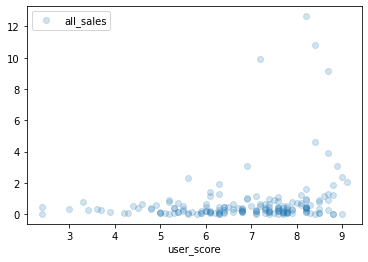

In [49]:
#Корреляция между оценками пользователей и продажами 
threeds =data[data['platform']=='3DS']
threeds.plot(x='user_score', y='all_sales', style = 'o',  alpha=0.2)
threeds['user_score'].corr(threeds['all_sales'])
#Корреляция очень слабая

0.3487397305984834

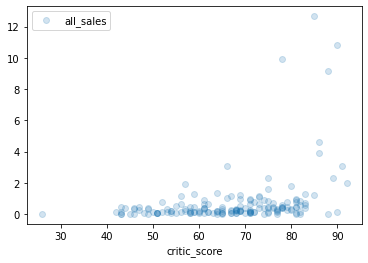

In [50]:
#Корреляция между оценками критиков и продажами 
threeds.plot(x='critic_score', y='all_sales', style = 'o',  alpha=0.2)
threeds['critic_score'].corr(threeds['all_sales'])
#Корреляция слабая

Корреляция между отзывами критиков и продажами для всех рассматриваемых платформ варьируется от слабой (X360, PS3, PS4, WIIU, 3DS, XONE) до очень слабой (WII, PSV, PC). Корреляция между отзывами других пользователей и продажами - от очень слабой (WII, X360, PS3, 3DS) до "не выявлена(PSV, PS4, XONE, PC ) - хотя для WIIU корреляция слабая.

В целом можно сказать, что оценки критиков имеют чуть большее влияние на мнение покупателей: вероятно, потому, что зачастую критики выкладывают "разборы", на которых обосновывают своё мнение, в то время как обычный пользователь чаще ставит оценку "молча" или с комментарием, выглядящим необъективно ("Не зашло"/ "лучшая  игра ЭвЕР"/...) -исходя из этого, сложно составить мнение об игре.

### Распределение по жанрам

In [51]:
distr_genre = actual.pivot_table(index='genre', values='all_sales', aggfunc='mean').sort_values(
    by='all_sales', ascending=False).reset_index()
distr_genre

,genre,all_sales
0,Shooter,1.245882
1,Sports,0.720817
2,Platform,0.582500
3,Role-Playing,0.508281
4,Racing,0.469294
5,Fighting,0.446709
6,Misc,0.428562
7,Action,0.426210
8,Simulation,0.353279
9,Puzzle,0.186471


Итак, лучше всего продаются шутеры, чуть хуже - Платформеры. Хуже всего - приключения.
// *Расстраивается за стратежки. Стратежки топ же...*

### "Портрет пользователя"

In [52]:
#Заглушка
actual['rating']=actual['rating'].fillna('Unknown')
actual.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       1168
user_score          969
rating                0
all_sales             0
dtype: int64

#### Северная Америка

,na_sales
genre,
Shooter,0.586845
Sports,0.313798
Platform,0.249028
Fighting,0.196835
Misc,0.188082
Action,0.167327
Role-Playing,0.162807
Racing,0.152471
Simulation,0.077869


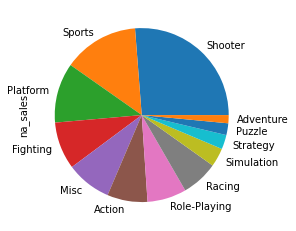

In [53]:
#Распределение по жанрам
NA_genre = actual.pivot_table(index='genre', values='na_sales', aggfunc='mean').sort_values(
    by='na_sales', ascending=False)
NA_genre['na_sales'].plot.pie()
NA_genre

,na_sales
platform,
X360,0.439032
XOne,0.377004
Wii,0.285217
PS4,0.277398
WiiU,0.254000
PS3,0.184058
3DS,0.126073
PC,0.058783
PSV,0.014078


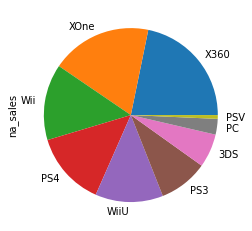

In [54]:
#Распределение по платформам
NA_platf = actual.pivot_table(index='platform', values='na_sales', aggfunc='mean').sort_values(
    by='na_sales', ascending=False)
NA_platf['na_sales'].plot.pie()
NA_platf

,na_sales
rating,
M,0.447724
E,0.266689
E10+,0.216080
T,0.149970
Unknown,0.097892


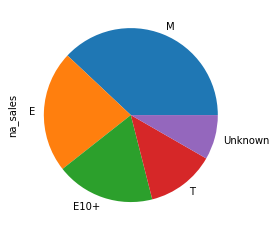

In [55]:
#Распределение по рейтингу
NA_rating = actual.pivot_table(index='rating', values='na_sales', aggfunc='mean').sort_values(
    by='na_sales', ascending=False)
NA_rating['na_sales'].plot.pie()
NA_rating

Итак, для Северной Америки:
* Предпочитаемые жанры: Шутер, платформеры  
* Предпочитаемые платформы: X360, XOne
* Больше всего тратят на игры "Для всех" и "Для взрослых".
*** 
* "Нелюбимый" жанр - Приключения
* "Нелюбимая" платформа - PSV
* Меньше всего трятят на игры "Для детей младшего возраста" (без учёта игр, которые ещё не успели оценить).

#### Европа

,eu_sales
genre,
Shooter,0.469840
Sports,0.290096
Racing,0.237529
Platform,0.210417
Simulation,0.177705
Action,0.156742
Misc,0.136986
Role-Playing,0.129719
Fighting,0.108228


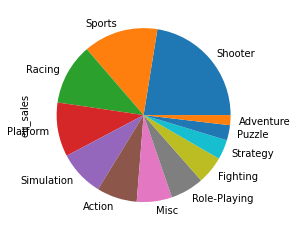

In [56]:
#Распределение по жанрам
EU_genre = actual.pivot_table(index='genre', values='eu_sales', aggfunc='mean').sort_values(
    by='eu_sales', ascending=False)
EU_genre['eu_sales'].plot.pie()
EU_genre

,eu_sales
platform,
PS4,0.359923
Wii,0.257826
X360,0.228602
XOne,0.208866
PS3,0.196551
WiiU,0.172609
PC,0.134180
3DS,0.102178
PSV,0.017039


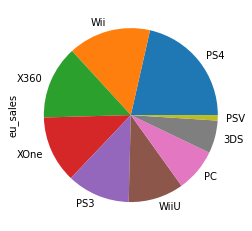

In [57]:
#Распределение по платформам
EU_platf = actual.pivot_table(index='platform', values='eu_sales', aggfunc='mean').sort_values(
    by='eu_sales', ascending=False)
EU_platf['eu_sales'].plot.pie()
EU_platf

,eu_sales
rating,
M,0.393821
E,0.279730
E10+,0.170120
T,0.126355
Unknown,0.086290


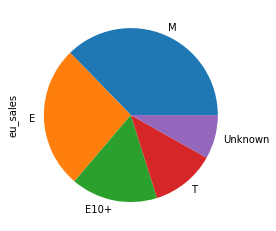

In [58]:
#Распределение по рейтингу
EU_rating = actual.pivot_table(index='rating', values='eu_sales', aggfunc='mean').sort_values(
    by='eu_sales', ascending=False)
EU_rating['eu_sales'].plot.pie(normalize=True)
EU_rating

Итак, для Европы:
* Предпочитаемые жанры: Платформер, Шутер.  
* Предпочитаемые платформы: PS3, PS4
* Больше всего тратят на игры "Для всех" и "Для взрослых".
***
* "Нелюбимый" жанр -  приключения
* "Нелюбимая" платформа - PSV
* Меньше всего трятят на игры "Для детей младшего возраста" (без учёта игр, которые ещё не успели оценить).
 
В целом, ситуация похожа на Северную Америку, за исключением величины потраченных сумм: в Северной Америке на игры в среднем тратят больше

#### Япония

,jp_sales
genre,
Role-Playing,0.175474
Fighting,0.096582
Simulation,0.074098
Puzzle,0.069412
Platform,0.066528
Misc,0.061849
Action,0.052726
Shooter,0.035348
Strategy,0.031818


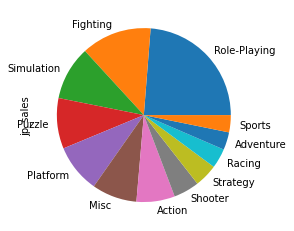

In [59]:
#Распределение по жанрам
JP_genre = actual.pivot_table(index='genre', values='jp_sales', aggfunc='mean').sort_values(
    by='jp_sales', ascending=False)
JP_genre['jp_sales'].plot.pie(normalize=True )
JP_genre

,jp_sales
platform,
PC,0.000000
XOne,0.001377
Wii,0.002174
X360,0.002742
PS4,0.040714
PSV,0.051927
PS3,0.067681
WiiU,0.094609
3DS,0.223795


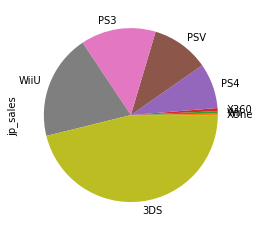

In [60]:
#Распределение по платформам
JP_platf = actual.pivot_table(index='platform', values='jp_sales', aggfunc='mean').sort_values(
    by='jp_sales', ascending=True)
JP_platf['jp_sales'].plot.pie(normalize=True)
JP_platf

,jp_sales
rating,
Unknown,0.090066
T,0.061566
E,0.050676
M,0.038238
E10+,0.023560


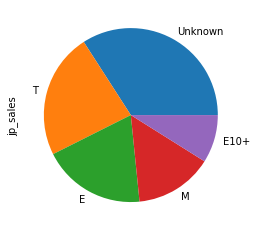

In [61]:
#Распределение по рейтингу
JP_rating = actual.pivot_table(index='rating', values='jp_sales', aggfunc='mean').sort_values(
    by='jp_sales', ascending=False)
JP_rating['jp_sales'].plot.pie(normalize=True)
JP_rating

Итак, для Японии:
* Предпочитаемые жанры: Ролевые, платформеры.  
* Предпочитаемые платформы:  3DS, WiiU.
* Больше всего тратят на игры "Для всех" и "Для подростков".
***
* "Нелюбимый" жанр - приключения
* "Нелюбимая" платформа - PC
* Меньше всего трятят на игры "Для детей младшего возраста" (без учёта игр, которые ещё не успели оценить).

На игры тратят меньше чем в Северной Америке и Европе

#### Другие страны

,other_sales
genre,
Shooter,0.153850
Sports,0.093317
Platform,0.056528
Racing,0.052235
Action,0.049415
Fighting,0.045063
Misc,0.041644
Role-Playing,0.040281
Simulation,0.023607


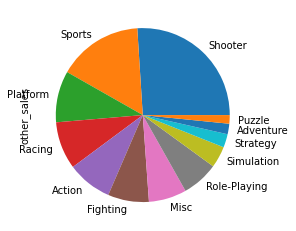

In [62]:
#Распределение по жанрам
Oth_genre = actual.pivot_table(index='genre', values='other_sales', aggfunc='mean').sort_values(
    by='other_sales', ascending=False)
Oth_genre['other_sales'].plot.pie(normalize=True)
Oth_genre

,other_sales
platform,
PS4,0.123342
PS3,0.077594
X360,0.065108
XOne,0.057773
Wii,0.048696
WiiU,0.040783
3DS,0.020726
PC,0.015661
PSV,0.009106


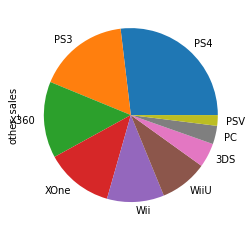

In [63]:
#Распределение по платформам
Oth_platf = actual.pivot_table(index='platform', values='other_sales', aggfunc='mean').sort_values(
    by='other_sales', ascending=False)
Oth_platf['other_sales'].plot.pie(normalize=True)
Oth_platf

,other_sales
rating,
M,0.127480
E,0.076115
E10+,0.050160
T,0.043042
Unknown,0.025697


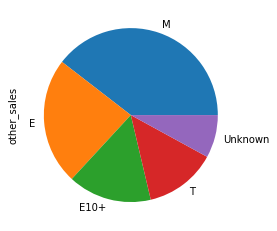

In [64]:
#Распределение по рейтингу
Oth_rating = actual.pivot_table(index='rating', values='other_sales', aggfunc='mean').sort_values(
    by='other_sales', ascending=False)
Oth_rating['other_sales'].plot.pie(normalize=True)
Oth_rating

Итак, для других стран:
* Предпочитаемые жанры: Экшн, платформер.  
* Предпочитаемые платформы: PS3, PS4
* Больше всего тратят на игры "Для всех" и "Для взрослых".
***
* "Нелюбимый" жанр - Puzzle
* "Нелюбимая" платформа - PSV
* Меньше всего трятят на игры "Для детей младшего возраста" (без учёта игр, которые ещё не успели оценить).

Траты на игры сравнимы с Японией

#### Вывод:  
Самыми популярными платформами являются X360, PS4 и PS3 и жанры платформер и шутер - везде, кроме Японии. Для Японии самыми популярными стали платформы 3DS и также WiiU, а самыми популярными жанрами - ролевые и платформеры.

Лучше всего продаются игры с рейтингом "для всех". В Японии на втором месте игры с рейтингом "для тинейджеров", в других регионах (включая Европу и Северную Америку) предпочитают рейтинг "только для взрослых".

Во всех регионах хуже всего продаются игры жанра приключения и игры с рейтингом "для детей младшего возраста". Мне кажется, это объяснимо наличием альтернатив in real life, так что люди не готовы платить деньги за то, что у них и без компьютера есть. Детей младшего возраста также обычно либо стараются занять чем-то в реальности, либо же скачивают игру "чтобы сидел и не мешал" - соответственно, не готовы платить за это много денег. Кроме того, себестоимость создания игры для детей меньше (графика может быть попроще, механика полегче...) - хотя это исключительно мои предположения. В случае приключений же проще скачать пиратскую версию, и сложнее спалиться, мне кажется.

Больше всего на игры тратят в Северной Америке. На втором месте Европа, на третьея - Япония и другие регионы.

Лучше всего игры без рейтинга продаются в Японии, хуже всего - в Северной Америке. Возможно, связано с тем, что ERSB -  негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде,  и связь, скорее, обратная - организация быстрее оценивает те игры, которые стали популярными в США и Канаде

### Проверка гипотез
Для проверки обеих гипотез будем использовать t-критерий Стьюдента, т.к. в обоих случаях выборки независимы.
Определим пороговое значение alpha = 0.05

####  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC равны.

Альтернативная: Средние пользовательские рейтинги платформ Xbox One и PC  не равны.

In [65]:
#Не забываем, что рассматриваем только актуальный период
x_one = data[(data['platform']=='XOne')& (data['year_of_release']>2013)]['user_score']
pc = data[(data['platform']=='PC')& (data['year_of_release']>2013)]['user_score']
alpha = 0.05


results = st.ttest_ind(x_one.dropna(), pc.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


####  Средние пользовательские рейтинги жанров Action и Sports  разные

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports равны.

Альтернативная: Средние пользовательские рейтинги жанров Action и Sports не равны.

In [66]:
#Не забываем, что рассматриваем только актуальный период
action = data[(data['genre']=='Action')& (data['year_of_release']>2013)]['user_score']
sport = data[(data['genre']=='Sports')& (data['year_of_release']>2013)]['user_score']
alpha = 0.05


results = st.ttest_ind(action.dropna(), sport.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Итак,  средние пользовательские рейтинги платформ Xbox One и PC действительно равны (вероятность получить наблюдаемый результат - 0,26), а рейтинги  жанров Action и Sports не равны (вероятности получить одинаковые рейтинги по двум жанрам почти нет, ибо 10^-13)

## Вывод

Был изучен и обработан массив данных о продажах игр за 36 лет. 

* Предобработка: 

В результате предобработки данных мы убедились, что предоставленные данные адекватны: нет невозможных значений оценок критиков или пользователей, а также годов выпуска; нет дубликатов. Есть пропуски в столбцах year_of_release, user_score и critic_score: в первом случае часть пропусков заполнили с помощью информации с других платформ, в последних двух оставили, как есть, т.к вероятнее всего это не ошибка, и этих оценок действительно нет. Обозначения "tbd" - to be determined - также означающие, что оценок ещё нет, были приведены к общему виду NaN. Названия колонок были приведены к классическому виду "snake_case". Также был создан столбец all_sales с суммарными продажами игры в мире.

* Зависимость количества выпущенных игр от года выпуска; определение актуального периода:

Начиная примерно с 1995 года количество выпускаемых игр в год стало резко возрастать. Вероятно, это связано с развитием технологий и возрастанием доступности ПК для обычных пользователей. Пик приходится приблизительно на 2008-2009 год, после чего начинается спад. Это можно объяснить развитием мобильных телефонов: часть аудитории, а следовательно, и часть разработчиков, перешла от консольных игр к мобильным приложениям. Кроме того, из-за растущей конкуренции (а ведь старые игры всё ещё доступны по большей части) разработчикам приходится вкладывать больше усилий и времени в игру, чтобы та стала популярной и покрыло затраты. К 2016 году количество выпускаемых консольных игр за год находится приблизительно на уровне 2002-2003 года. 

Среднее время жизни платформ - примерно 8-10 лет. Причём к 2016 году большая часть из рассматриваемых платформ уже прекратило своё существование. Актуальным мы посчитали период 2009-2016 год - когда количество выпускаемых за год игр начало снижаться. Также рассматривались только "актуальные" платформы - дожившие до 2016 года (Wii, X360, PS3, PSV, PS4, WiiU, XOne, PC, 3DS).

 * Корреляция между продажами и отзывами пользователей/критиков:
 
Корреляция между отзывами критиков и продажами для всех рассматриваемых платформ варьируется от слабой (X360, PS3, PS4, WIIU, 3DS, XONE) до очень слабой (WII, PSV, PC). Корреляция между отзывами других пользователей и продажами - от очень слабой (WII, X360, PS3, 3DS) до "не выявлена(PSV, PS4, XONE, PC ) - хотя для WIIU корреляция слабая.   
В целом можно сказать, что оценки критиков имеют чуть большее влияние на мнение покупателей: вероятно, потому, что зачастую критики выкладывают "разборы", на которых обосновывают своё мнение, в то время как обычный пользователь чаще ставит оценку "молча" или с комментарием, выглядящим необъективно.


 * Предпочтения: жанры, платформы, рейтинг:
 
Самыми популярными платформами являются X360, PS4 и PS3 и жанры платформер и шутер - везде, кроме Японии. Для Японии самыми популярными стали платформы 3DS и также WiiU, а самыми популярными жанрами - ролевые и платформеры.

Лучше всего продаются игры с рейтингом "для всех". В Японии на втором месте игры с рейтингом "для тинейджеров", в других регионах (включая Европу и Северную Америку) предпочитают рейтинг "только для взрослых".

Во всех регионах хуже всего продаются игры жанра приключения и игры с рейтингом "для детей младшего возраста". Мне кажется, это объяснимо наличием альтернатив in real life, так что люди не готовы платить деньги за то, что у них и без компьютера есть. Детей младшего возраста также обычно либо стараются занять чем-то в реальности, либо же скачивают игру "чтобы сидел и не мешал" - соответственно, не готовы платить за это много денег. Кроме того, себестоимость создания игры для детей меньше (графика может быть попроще, механика полегче...) - хотя это исключительно мои предположения. В случае приключений же проще скачать пиратскую версию, и сложнее спалиться, мне кажется.

Больше всего на игры тратят в Северной Америке. На втором месте Европа, на третьея - Япония и другие регионы.

Лучше всего игры без рейтинга продаются в Японии, хуже всего - в Северной Америке. Возможно, связано с тем, что ERSB -  негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде,  и связь, скорее, обратная - организация быстрее оценивает те игры, которые стали популярными в США и Канаде.

 * Проверка гипотез:
     * Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
     * Средние пользовательские рейтинги жанров Action  и Sports разные.

Обе гипотезы подтверждены (в первом случае нулевая гипотеза о равенстве не отвергнута, во втором случае - отвергнута).  Средние пользовательские рейтинги платформ Xbox One и PC действительно равны (вероятность получить наблюдаемый результат - 0,26), а рейтинги  жанров Action и Sports не равны (вероятности получить одинаковые рейтинги по двум жанрам почти нет, ибо 10^-13)